# Variational Bayes Mixture of Gaussian

In [4]:
import jax
import requests
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from io import StringIO
from jax import random

In [5]:
jnp.set_printoptions(suppress=True, precision=5)

In [6]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
url = "https://raw.githubusercontent.com/probml/pyprobml/master/data/faithful.txt"
r = requests.get(url)
r

<Response [200]>

In [8]:
data = np.loadtxt(StringIO(r.text))
data = jnp.array(data)
data[:5]

DeviceArray([[ 3.6  , 79.   ],
             [ 1.8  , 54.   ],
             [ 3.333, 74.   ],
             [ 2.283, 62.   ],
             [ 4.533, 85.   ]], dtype=float32)

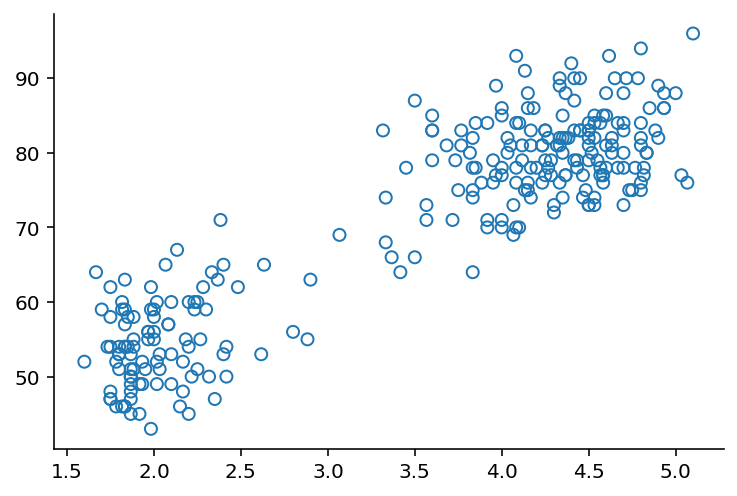

In [9]:
plt.scatter(*data.T, facecolor="none", edgecolor="tab:blue")

In [10]:
from scipy import stats as scistats
from jax.scipy import special, stats
from jax.numpy.linalg import det, inv
#from jax.scipy.stats import multivariate_normal

In [11]:
import numpy as np
def plot_mixtures(X, r, mu, pi, Sigma, step=0.01, cmap="viridis", levels=1):
    colors = ["tab:red", "tab:blue", "tab:green",
              "tab:cyan", "tab:orange", "tab:purple"]
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]
    Nk = r.sum(axis=0)
    
    # Plotting distributions whose effective number of
    # observations is at least 1
    Norms = [scistats.multivariate_normal(mean=mui, cov=Sigmai)
             for mui, Sigmai, N in zip(mu, Sigma, Nk) if N > 1]
    
    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        plt.contour(xx, yy, density, levels=levels,
                    colors=color, linewidths=3)
        
    plt.scatter(*X.T, alpha=0.7, c=r.argmax(axis=1), cmap=cmap)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)


In [12]:
def compute_e_log_pi(alpha):
    """
    Compute the expected value of every log pi_k, i.e.,
    compute ∀k. E[log pi_k]
    """
    return special.digamma(alpha) - special.digamma(alpha.sum())


def compute_e_log_lambda(X, eta, W):
    """
    Compute the expected value of every log det Lambda_k, i.e,
    compute ∀k. E[log|Lambda_k|]
    """
    N, M = X.shape
    return special.digamma((eta + 1 - M) / 2) + M * jnp.log(2) + det(W)

@jax.jit
def compute_responsibilities(X, alpha, beta, eta, m, W):
    """
    Compute model responsibilities
    (Variational E-Step)
    """
    N, M = X.shape
    E_logpi = compute_e_log_pi(alpha)
    E_logLambda = compute_e_log_lambda(X, eta, W)
    diffk = (X[:, None, :] - m.T)
    mpart = jnp.einsum("ijk,jkk->ijk", diffk, W)
    E_mahal = eta * jnp.einsum("ijk,ijk->ij", mpart, diffk) + M / beta
    
    log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * jnp.log(2 * jnp.pi) - E_mahal / 2
    
    r = jax.nn.softmax(log_rho_nk)
    return r


def expected_values(X, r, alpha, beta, eta, m, W):
    """
    Compute the expected values for the parameters
    π_k, μ_k and Λ_k of the re-estimation equations
    for the lower-bound.
    """
    pi_k = alpha / alpha.sum()
    mu_k = m.T
    Sigma_k = inv(eta[:, None, None] * W)
        
    return pi_k, mu_k, Sigma_k

def compute_m_statistics(X, r):
    Nk = r.sum(axis=0) + 1e-6
    xbar_k = (X[..., None] * r[:, None, :]).sum(axis=0) / Nk
    Sk = (X[..., None] - xbar_k)[..., None, :]
    Sk = jnp.einsum("il,ijkl,ikjl->kjl", r, Sk, Sk) / Nk
    
    return Nk, xbar_k, Sk

@jax.jit
def posterior_params(X, r, alpha, beta, eta, m, W):
    """
    Compute the posterior parameters for each
    components of the mixture of gaussians
    (Variational M-Step)
    """
    Nk, xbar_k, Sk = compute_m_statistics(X, r)
    alpha_k = alpha + Nk
    beta_k = beta + Nk
    eta_k = eta + Nk
    
    m_k = (beta * m + Nk * xbar_k) / beta_k
    C0 = (beta * Nk) / (beta + Nk)
    f0 = (xbar_k - m)[:, None, :]
    W_k_inv = inv(W) + (Nk * Sk).T + C0[:, None, None] * jnp.einsum("ijk,jik->kij", f0, f0)
    W_k = inv(W_k_inv)
    
    return alpha_k, beta_k, eta_k, m_k, W_k

In [13]:
X = (data - data.mean(axis=0)) / data.std(axis=0)

In [14]:
# Prior parameters
key = random.PRNGKey(314)
N, M = X.shape
K = 6 

m_0 = X.mean(axis=0, keepdims=True).T * jnp.ones((M, K)) 
m_0 = m_0 + random.normal(key, (M, K))
print(m_0.shape)

beta_0 = jnp.ones(K)
alpha_0 = jnp.ones(K) * 0.0001
eta_0 = 4 * jnp.ones(K)

W_0 = jnp.eye(M)[None, ...] * jnp.ones((K, 1, 1)) / 5

(2, 6)


In [17]:
r_nk = compute_responsibilities(X, alpha_0, beta_0, eta_0, m_0, W_0)
pi_0, mu_0, Sigma_0 = expected_values(X, r_nk, alpha_0, beta_0, eta_0, m_0, W_0)

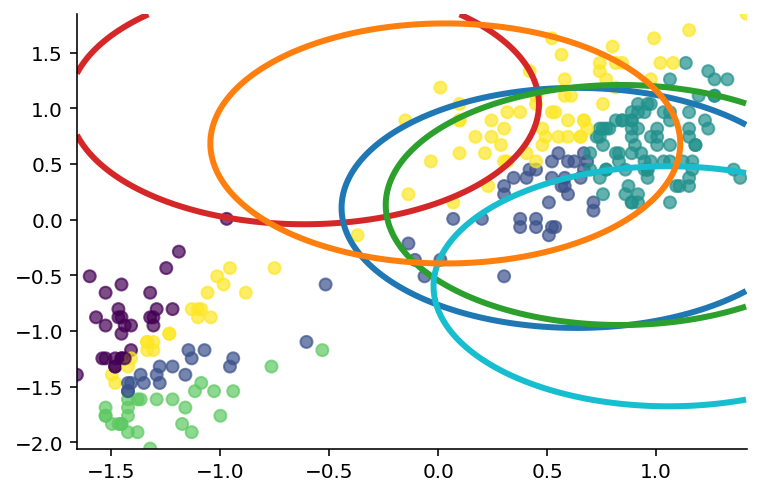

In [18]:
plot_mixtures(X, r_nk, mu_0, pi_0, Sigma_0)

In [19]:
%%time
steps = []
nits = 500

r_nk = compute_responsibilities(X, alpha_0, beta_0, eta_0, m_0, W_0)
# alpha_k, beta_k, eta_k, m_k, W_k = alpha_0, beta_0, eta_0, m_0, W_0
for i in range(nits):
    
    alpha_k, beta_k, eta_k, m_k, W_k = posterior_params(X, r_nk, alpha_0, beta_0, eta_0, m_0, W_0)
    r_nk = compute_responsibilities(X, alpha_k, beta_k, eta_k, m_k, W_k)

    values = {
        "r": r_nk,
        "alpha": alpha_k,
        "beta": beta_k,
        "eta": eta_k,
        "m": m_k,
        "W": W_k
    }
    steps.append(values)

CPU times: user 1.02 s, sys: 21.8 ms, total: 1.04 s
Wall time: 1 s


In [20]:
r_nk.sum(axis=0)

DeviceArray([  0.     ,  97.32172,   0.     , 174.67827,   0.     ,
               0.     ], dtype=float32)

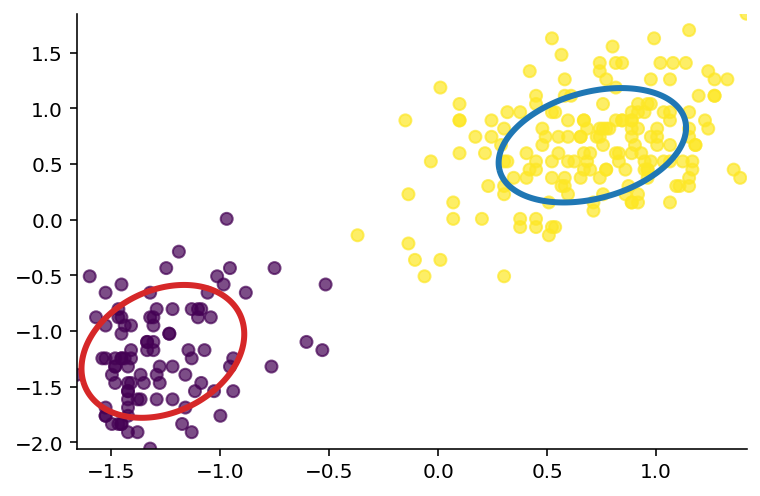

In [21]:
pi_k, mu_k, Sigma_k = expected_values(X, r_nk, alpha_k, beta_k, eta_k, m_k, W_k)
plot_mixtures(X, r_nk,  mu_k, pi_k, Sigma_k, levels=1)

## Building a class

In [214]:
from importlib import reload
import variational_mixture_gaussians as vmg

In [215]:
# Prior parameters
key = random.PRNGKey(3141)
N, M = X.shape
K = 6 

m_0 = X.mean(axis=0, keepdims=True).T * jnp.ones((M, K)) 
m_0 = m_0 + random.normal(key, (M, K))
print(m_0.shape)

beta_0 = jnp.ones(K)
alpha_0 = jnp.ones(K)  * 0.001
eta_0 =  4 * jnp.ones(K)

W_0 = jnp.eye(M)[None, ...] * jnp.ones((K, 1, 1)) / 5

(2, 6)


In [225]:
beta_0

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

In [216]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=314)
kmeans.fit(X)
m_0 = kmeans.cluster_centers_.T

In [217]:
reload(vmg)

<module 'variational_mixture_gaussians' from '/Users/gerardoduran/Documents/repos/misc/2021-06/variational_mixture_gaussians.py'>

In [218]:
vbmixture = vmg.VBMixture()

In [219]:
%%time
hist = vbmixture.fit(X, m_0, W_0, beta_0, alpha_0, eta_0, 100, store_hist=True)

CPU times: user 3.28 s, sys: 61.5 ms, total: 3.34 s
Wall time: 3.33 s


In [220]:
iterations = jnp.arange(100)

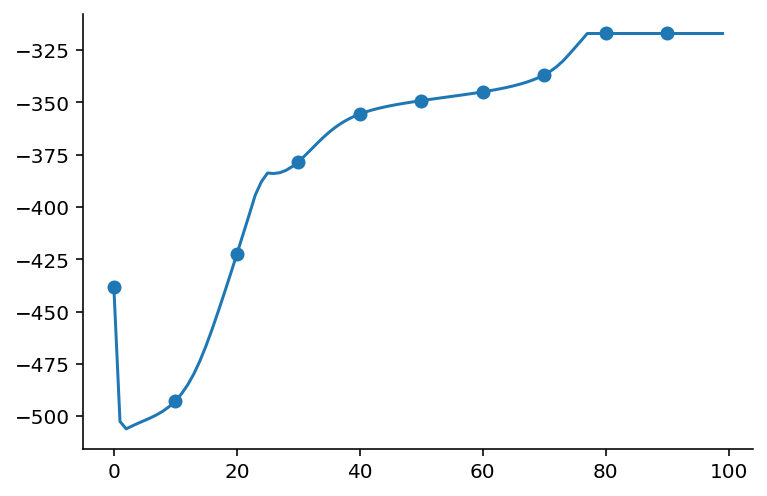

In [221]:
plt.plot(vbmixture.lower_bound_hist)
plt.scatter(iterations[::10], vbmixture.lower_bound_hist[::10])

In [229]:
Sigma_k.shape

(6, 2, 2)

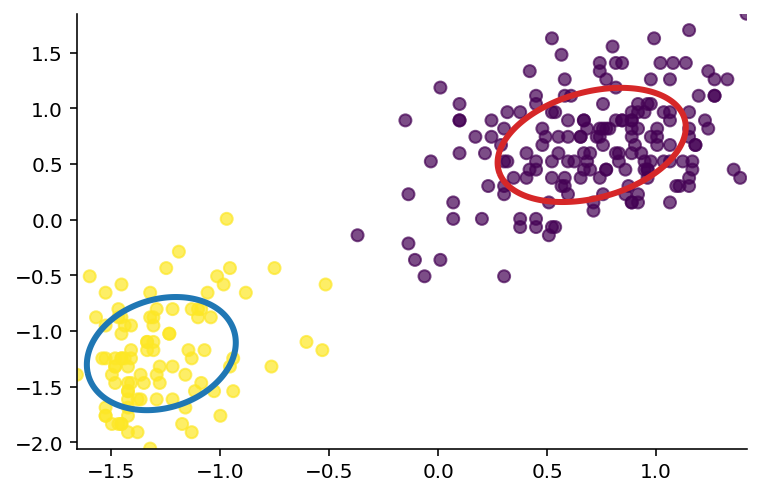

In [222]:
pi_k, mu_k, Sigma_k = vbmixture.expected_values()
plot_mixtures(X, vbmixture.r_nk, mu_k, pi_k, Sigma_k, levels=1)

Text(0.5, 1.0, 'iter 1')

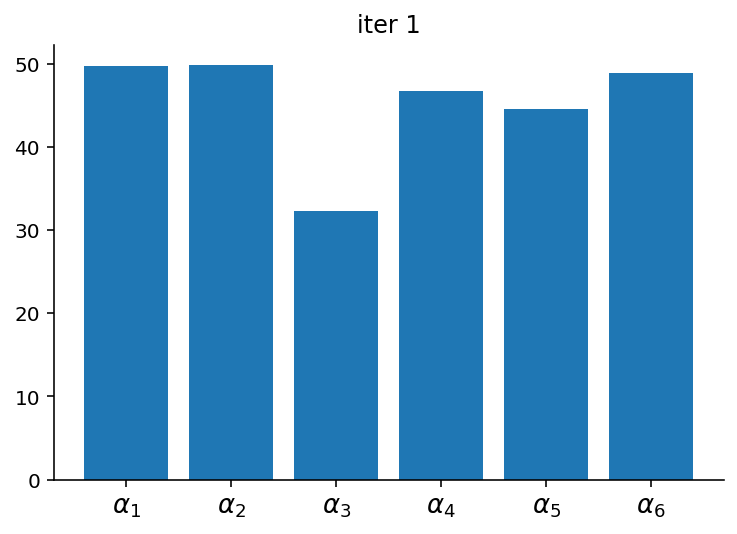

In [169]:
fig, ax = plt.subplots()
ax.bar(np.arange(K), hist[1]["alpha"])
ax.set_xticks(range(K))
ax.set_xticklabels([r"$\alpha_"f"{k+1}$" for k in range(K)], fontsize=13);
ax.set_title("iter 1")

Text(0.5, 1.0, 'Iter 100')

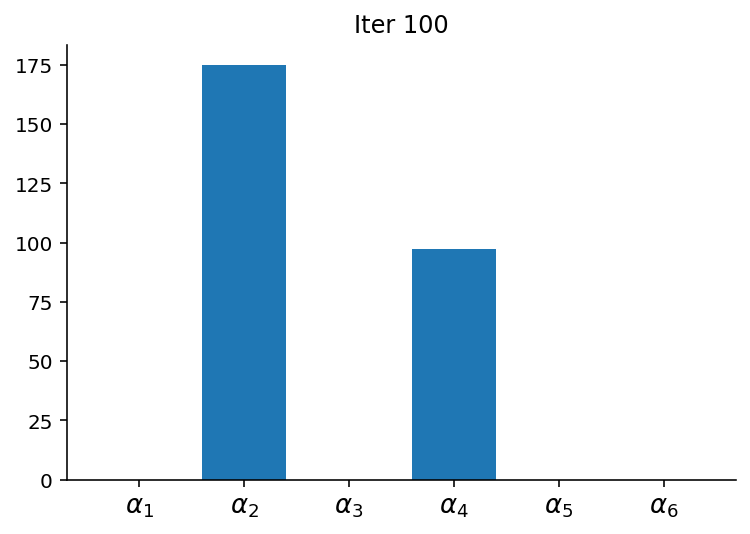

In [170]:
fig, ax = plt.subplots()
ax.bar(np.arange(K), vbmixture.alpha_k)
ax.set_xticks(range(K))
ax.set_xticklabels([r"$\alpha_"f"{k+1}$" for k in range(K)], fontsize=13)
ax.set_title("Iter 100")